In [1]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
%matplotlib inline

In [2]:
frames = []

In [ ]:
import glob
files2016 = glob.glob('data/LoanStats_2016*.csv')
for file in files2016:
    data = pd.read_csv(file,skiprows=1,low_memory=False)
    frames.append(data)

In [ ]:
files2017 = glob.glob('data/LoanStats_2017*.csv')
for file in files2017:
    data = pd.read_csv(file,skiprows=1,low_memory=False)
    frames.append(data)

In [ ]:
data = pd.read_csv('data/LoanStats4.csv',skiprows=1,low_memory=False)
frames.append(data)

In [ ]:
filesremain = glob.glob('data/LoanStats3*.csv')
for file in filesremain:
    data = pd.read_csv(file,skiprows=1,low_memory=False)
    frames.append(data)

In [ ]:
loan=pd.concat(frames)
print(loan.shape)
loan.head()

In [ ]:
loan = loan.iloc[:,2:36]
col = loan.columns

In [ ]:
import dill
dill.dump(loan, open('loans.pkd', 'wb'))

In [3]:
import dill
loan = dill.load(open('loans.pkd', 'rb'))
col = loan.columns

In [4]:
drop_cols=[]
check_val = 0.9*loan.shape[0]
for c in col:
    if loan[c].isnull().sum() > check_val:
        drop_cols.append(c)
loan.drop(drop_cols,axis=1,inplace=True)
loan.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1765451 entries, 0 to 42537
Data columns (total 32 columns):
loan_amnt                 float64
funded_amnt               float64
funded_amnt_inv           float64
term                      object
int_rate                  object
installment               float64
grade                     object
sub_grade                 object
emp_title                 object
emp_length                object
home_ownership            object
annual_inc                float64
verification_status       object
issue_d                   object
loan_status               object
pymnt_plan                object
purpose                   object
title                     object
zip_code                  object
addr_state                object
dti                       float64
delinq_2yrs               float64
earliest_cr_line          object
inq_last_6mths            float64
mths_since_last_delinq    float64
mths_since_last_record    float64
open_acc             

In [5]:
loan.isnull().sum()

loan_amnt                      25
funded_amnt                    25
funded_amnt_inv                25
term                           25
int_rate                       25
installment                    25
grade                          25
sub_grade                      25
emp_title                  112335
emp_length                 104945
home_ownership                 25
annual_inc                     29
verification_status            25
issue_d                        25
loan_status                    25
pymnt_plan                     25
purpose                        25
title                       23350
zip_code                       26
addr_state                     25
dti                           604
delinq_2yrs                    54
earliest_cr_line               54
inq_last_6mths                 55
mths_since_last_delinq     881875
mths_since_last_record    1469279
open_acc                       54
pub_rec                        54
revol_bal                      25
revol_util    

In [6]:
loan.drop(['zip_code','mths_since_last_delinq','revol_util','dti','mths_since_last_record',
          'funded_amnt', 'funded_amnt_inv'],axis=1,inplace=True)
loan.emp_length.fillna(0,inplace=True)
loan.emp_title.fillna('NA',inplace=True)
loan.emp_title.isnull().sum()
loan.dropna(inplace=True)

In [7]:
print(loan.shape)
loan.head(1)

(1742071, 25)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,title,addr_state,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status
0,4500.0,36 months,11.49%,148.38,B,B5,Server,1 year,RENT,30000.0,...,Debt consolidation,NE,1.0,Jun-2012,0.0,9.0,0.0,3329.0,10.0,f


In [8]:
#import warnings
#warnings.filterwarnings('ignore')
import ab_state as cs
page = 'https://en.wikipedia.org/wiki/List_of_U.S._states_by_income'
infoboxes = pd.read_html(page)
state_sal = infoboxes[2]
state_sal.rename(columns=state_sal.iloc[0],inplace=True)
state_sal=state_sal.iloc[1:53,1:] 
state_sal.columns=['State','2015','2014','2013','2012','2011']
state_sal.replace({"State": cs.states},inplace=True)
state_sal['2015']=state_sal['2015'].str.replace('$','')
state_sal['2014']=state_sal['2012'].str.replace('$','')
state_sal['2013']=state_sal['2013'].str.replace('$','')
state_sal['2012']=state_sal['2012'].str.replace('$','')
state_sal['2011']=state_sal['2011'].str.replace('$','')
state_sal['2015']=state_sal['2015'].str.replace(',','').astype(float)
state_sal['2014']=state_sal['2012'].str.replace(',','').astype(float)
state_sal['2013']=state_sal['2013'].str.replace(',','').astype(float)
state_sal['2012']=state_sal['2012'].str.replace(',','').astype(float)
state_sal['2011']=state_sal['2011'].str.replace(',','').astype(float)
state_sal['avg_sal'] = state_sal.iloc[:,2:].mean(axis=1)
avg_sal_dict = state_sal.set_index('State').to_dict()['avg_sal']
loan['state_avg_sal']=loan['addr_state'].map(avg_sal_dict)

In [9]:
'ap'.upper()

'AP'

In [10]:
# Other new columns for the model
loan['loan_inc_ratio'] = loan['loan_amnt']/loan['annual_inc'].replace(0, np.inf)

In [11]:
#drop more columns
loan.drop(['issue_d','title','earliest_cr_line','total_acc','initial_list_status','revol_bal'],axis=1,inplace=True)

In [12]:
loan['term']=loan.term.str.split().str[0].astype(int)
loan['int_rate']=loan.int_rate.str.replace('%','').astype(float)
loan['emp_length']=loan.emp_length.str.extract('(\d+)').astype(float)
loan.emp_length.fillna(0,inplace=True)

In [13]:
# changing the verification status, payment plan to nominal values
func1 = lambda x: 1 if x=='Source Verified' else 0
loan['verification_status']=loan.verification_status.apply(func1)

func3 = lambda x: 1 if (x=='y') else 0
loan['pymnt_plan'] = loan.pymnt_plan.apply(func3)

In [14]:
loan.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'pymnt_plan', 'purpose',
       'addr_state', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'state_avg_sal', 'loan_inc_ratio'],
      dtype='object')

In [15]:
df=loan
cor = df.corr()
cor

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,verification_status,pymnt_plan,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,state_avg_sal,loan_inc_ratio
loan_amnt,1.000000,0.397439,0.134109,0.946725,0.110871,0.190365,0.018637,0.005577,-0.004105,-0.025532,0.188359,-0.059578,0.039662,0.004480
term,0.397439,1.000000,0.391714,0.142400,0.070111,0.035535,0.024545,0.003063,-0.006032,-0.000994,0.078124,-0.019995,-0.006958,0.001732
int_rate,0.134109,0.391714,1.000000,0.152479,-0.009781,-0.047557,0.018284,0.008599,0.045926,0.204552,-0.007107,0.054319,-0.013800,0.000614
installment,0.946725,0.142400,0.152479,1.000000,0.095476,0.182682,0.013691,0.006549,0.004325,0.001821,0.176325,-0.047157,0.043039,0.004066
emp_length,0.110871,0.070111,-0.009781,0.095476,1.000000,0.059937,0.001253,-0.002614,0.025870,0.001133,0.063601,0.012866,0.011041,-0.004492
annual_inc,0.190365,0.035535,-0.047557,0.182682,0.059937,1.000000,0.027796,0.000305,0.023894,0.018438,0.084020,-0.000567,0.040068,-0.002330
verification_status,0.018637,0.024545,0.018284,0.013691,0.001253,0.027796,1.000000,0.001378,0.020508,-0.016059,-0.023519,0.035393,0.000754,-0.002289
pymnt_plan,0.005577,0.003063,0.008599,0.006549,-0.002614,0.000305,0.001378,1.000000,0.002062,0.000327,0.002184,0.003443,0.000345,-0.000023
delinq_2yrs,-0.004105,-0.006032,0.045926,0.004325,0.025870,0.023894,0.020508,0.002062,1.000000,0.021922,0.053182,-0.022193,0.014771,-0.000021
inq_last_6mths,-0.025532,-0.000994,0.204552,0.001821,0.001133,0.018438,-0.016059,0.000327,0.021922,1.000000,0.132378,0.060470,-0.014459,-0.001131


In [16]:
#drop installment
loan.drop(['installment'],axis=1,inplace=True)


In [17]:
#import skflow
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

/opt/conda/envs/data3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
#score deduction based on current status
status_deduct_dict = {
"Fully Paid": 0,
"Current": 0,                                               
"Charged Off": 1,                                           
"Late (31-120 days)":1,                                    
"In Grace Period": 1,                                       
"Late (16-30 days)": 1,                                     
"Does not meet the credit policy. Status:Fully Paid":0,    
"Does not meet the credit policy. Status:Charged Off":1,
"Default":1
}
loan['status'] = loan['loan_status'].map(status_deduct_dict)

In [19]:
loan.drop(['loan_status'],axis=1,inplace=True)

In [20]:
len(set(loan['emp_title']))

446207

In [21]:

#test= loan[:100]
#test.shape
test2 = loan[['grade','sub_grade','home_ownership','purpose','addr_state']]

In [22]:
test3= loan[['loan_amnt', 'term', 'int_rate','emp_length', 'annual_inc','verification_status', 
            'pymnt_plan','delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
            'state_avg_sal', 'loan_inc_ratio']]

In [23]:
#test3 = test3[:100]
test4 = pd.get_dummies(test2)

In [24]:
final_test=pd.concat([test3,test4],axis=1)

In [25]:
test3.delinq_2yrs.value_counts()

0.0     1398172
1.0      226944
2.0       67504
3.0       24734
4.0       11041
5.0        5609
6.0        3156
7.0        1754
8.0        1038
9.0         676
10.0        450
11.0        303
12.0        218
13.0        142
14.0        102
15.0         73
16.0         43
18.0         26
17.0         21
19.0         19
20.0         15
21.0          9
22.0          5
26.0          3
25.0          2
24.0          2
29.0          2
30.0          2
32.0          1
27.0          1
42.0          1
39.0          1
36.0          1
28.0          1
Name: delinq_2yrs, dtype: int64

In [26]:
app_cols = final_test.columns.tolist()
d=dict.fromkeys(app_cols,0.0)

In [27]:
loan[loan.isnull().any(axis=1)]

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,state_avg_sal,loan_inc_ratio,status


In [28]:
t_size = 0.2
response = loan['status']
#test.drop(['status'],axis=1,inplace=True)
x_vals = final_test.values
x_vals = x_vals.astype(float)
X_train, X_test, y_train, y_test = train_test_split(x_vals, response, test_size=t_size, random_state=25)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1393656, 126) (348415, 126) (1393656,) (348415,)


In [29]:
import numpy as np
sum(np.isnan(x_vals==True))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
classifier = RandomForestClassifier(n_estimators = 15)
estimate = classifier.fit(X_train, y_train)
estimate

In [30]:
classifier = LogisticRegression(solver='saga')
estimate = classifier.fit(X_train, y_train)
estimate

/opt/conda/envs/data3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

Classification Report
             precision    recall  f1-score   support

          0       0.86      1.00      0.93    299799
          1       0.00      0.00      0.00     48616

avg / total       0.74      0.86      0.80    348415

Confusion Matrix:


/opt/conda/envs/data3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[299799      0]
 [ 48616      0]]


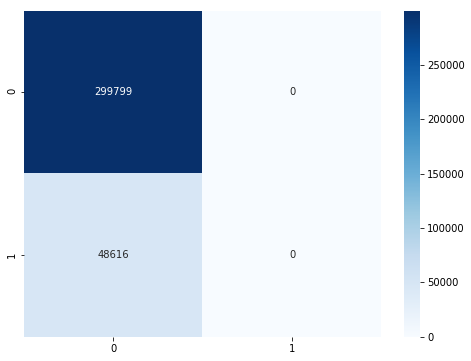

In [31]:
y_pred = classifier.predict(X_test)

#Classification Report
print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

#Confusion Matrix and Heatmap
print ("Confusion Matrix:")
log_matrix = metrics.confusion_matrix(y_test, y_pred)
print(log_matrix)


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(log_matrix,annot=True,cmap = 'Blues',ax = ax,fmt = 'g')

In [35]:
for i in range(10000):
    if classifier.predict_proba([x_vals[i]])[0][1] >= 0.2:
        print(classifier.predict_proba([x_vals[i]])[0][1])

0.207823652981764
0.2018970913304475
0.20863573215997516
0.21256345699351167
0.20786735547752705
0.2395586115036499
0.2003060091999758
0.20540063402311876
0.20758194692470675
0.20100307194429065
0.2369675044968667
0.20162298348266217
0.23941347154051631
0.2007061434412572
0.22160693868695838
0.21327102261666184
0.23000922889126862
0.20250602518940505
0.22330961434692023
0.21279518965829808
0.23894375403347
0.20007179766351252
0.20530395013429015
0.23204444666807764
0.20166409929812854
0.20396862521393064
0.2112069608003445
0.21615890039852093
0.21919609476467797
0.20285666492570376
0.22064536071649563
0.21105334710463997
0.2100152326766263
0.2158854559536153
0.21727314341776716
0.20998994185717354
0.2119905222269571
0.20598340107385607
0.20559076072952256
0.21964127171916392
0.2053158142417964
0.21218471623086033
0.221127103104637
0.20393603383669656
0.22115250230869568
0.2185933830894901
0.20817870771588257
0.24151028074170866
0.20204687150025327
0.20768054943812564
0.2035985778490162

In [ ]:
print(type(x_vals[1]))
p1 = np.array(list(d.values()))
p1 = p1.reshape(1, -1)

In [36]:
import pickle
# save the model to disk
filename = 'f2.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
claf1 = joblib.load('test_model.pickle')
preds = classifier.predict_proba(p1)
preds[0][1]

In [ ]:
preds[1]

In [ ]:
import pickle
classifier = pickle.load(open('finalized_model.sav', 'rb'))
#for i in range(1000):
#    if classifier.predict_proba([x_vals[i]])[0][1] >= 0.9:
#        print(classifier.predict_proba([x_vals[i]])[0][1])
#preds = [classifier.predict_proba([x_vals[i]])[0][1] for i in range(1000)]

In [48]:
import pickle
# save the model to disk
filename = 'tm2.pickle'
from sklearn.externals import joblib
joblib.dump(classifier,filename,compress=1)

['tm2.pickle']

In [37]:
preds = [classifier.predict_proba([x_vals[i]])[0][1] for i in range(len(x_vals))]

In [ ]:
import pickle
# save the model to disk
filename2 = 'preds2.sav'
pickle.dump(preds, open(filename2, 'wb'))

In [ ]:
preds=pickle.load(open('preds.sav', 'rb'))

In [ ]:
len(preds)

In [ ]:
len(final_test)

In [38]:
plot_df = loan[['annual_inc','state_avg_sal','addr_state','term','int_rate']] 

In [39]:
plot_df['pred']=preds

/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
plot_df['rel_sal'] = loan['annual_inc']/loan['state_avg_sal']
plot_df.drop(['annual_inc','state_avg_sal','term'],axis=1,inplace=True)
plot_df.columns

/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/data3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Index(['addr_state', 'int_rate', 'pred', 'rel_sal'], dtype='object')

In [47]:
import dill
dill.settings['recurse'] = True
dill.dump(plot_df, open('t2.pkd', 'wb'))


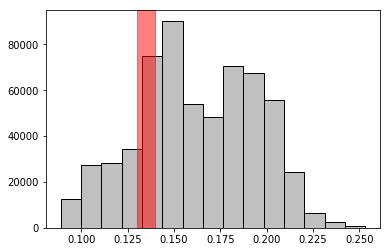

In [43]:

df1 = plot_df[(plot_df['rel_sal'] >= 0.75) & (plot_df['rel_sal'] < 1.25)]

plt.hist(df1.pred, color = 'silver', edgecolor = 'black',
         bins = 15)
plt.axvspan(0.13, 0.14, color='red', alpha=0.5)
plt.show()

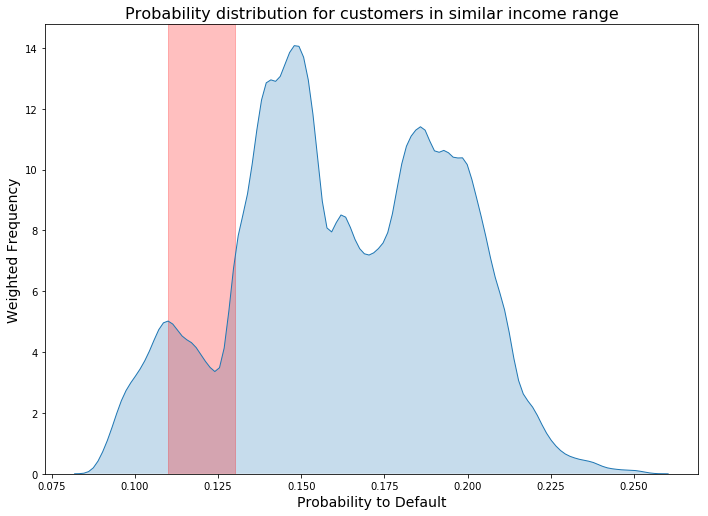

In [66]:
figa, ax = plt.subplots()
figa.set_size_inches(11.7, 8.27)
sns.distplot(df1.pred, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})
plt.axvspan(0.11, 0.13, color='red', alpha=0.25)
plt.xlabel('Probability to Default', fontsize=14)
plt.ylabel('Weighted Frequency', fontsize=14)
plt.title('Probability distribution for customers in similar income range', fontsize=16)
plt.show()


Text(0.5,1,'Probability distribution for customers in Illinois')

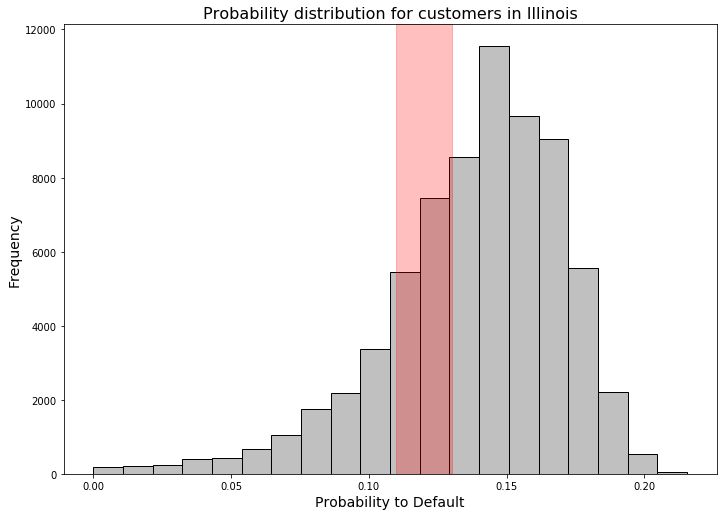

In [67]:
df2 = plot_df[plot_df['addr_state'] == 'IL']
figb, ax = plt.subplots()
figb.set_size_inches(11.7, 8.27)
plt.hist(df2.pred, color = 'silver', edgecolor = 'black',
         bins = 20)
plt.axvspan(0.11, 0.13, color='red', alpha=0.25)
plt.xlabel('Probability to Default', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Probability distribution for customers in Illinois', fontsize=16)

In [68]:
fig2

bokeh.plotting.figure.Figure(
    id='f88c16b9-3e01-4565-b347-78be945cc860',
    above=[],
    aspect_scale=1,
    background_fill_alpha={'value': 1.0},
    background_fill_color={'value': '#ffffff'},
    below=[bokeh.models.axes.LinearAxis(
         id='f1902e9e-32c4-4274-9660-ac9ffd461e31',
         axis_label='',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_label_text_color={'value': '#444444'},
         axis_label_text_font='helvetica',
         axis_label_text_font_size={'value': '10pt'},
         axis_label_text_font_style='italic',
         axis_label_text_line_height=1.2,
         axis_line_alpha={'value': 1.0},
         axis_line_cap='butt',
         axis_line_color={'value': 'black'},
         axis_line_dash=[],
         axis_line_dash_offset=0,
         axis_line_join='bevel',
         axis_line_width={'value': 1},
         bounds='auto',
         fixed_location=None,
         formatter=bokeh.models.formatters.BasicTickFormatter(
             id='7115d304-daac-495c-928f-51c716dc3806',
             js_event_callbacks={},
             js_property_callbacks={},
             name=None,
             power_limit_high=5,
             power_limit_low=-3,
             precision='auto',
             subscribed_events=[],
             tags=[],
             use_scientific=True),
         js_event_callbacks={},
         js_property_callbacks={},
         level='overlay',
         major_label_orientation='horizontal',
         major_label_overrides={},
         major_label_standoff=5,
         major_label_text_align='center',
         major_label_text_alpha={'value': 1.0},
         major_label_text_baseline='alphabetic',
         major_label_text_color={'value': '#444444'},
         major_label_text_font='helvetica',
         major_label_text_font_size={'value': '8pt'},
         major_label_text_font_style='normal',
         major_label_text_line_height=1.2,
         major_tick_in=2,
         major_tick_line_alpha={'value': 1.0},
         major_tick_line_cap='butt',
         major_tick_line_color={'value': 'black'},
         major_tick_line_dash=[],
         major_tick_line_dash_offset=0,
         major_tick_line_join='bevel',
         major_tick_line_width={'value': 1},
         major_tick_out=6,
         minor_tick_in=0,
         minor_tick_line_alpha={'value': 1.0},
         minor_tick_line_cap='butt',
         minor_tick_line_color={'value': 'black'},
         minor_tick_line_dash=[],
         minor_tick_line_dash_offset=0,
         minor_tick_line_join='bevel',
         minor_tick_line_width={'value': 1},
         minor_tick_out=4,
         name=None,
         plot=bokeh.plotting.figure.Figure(id='f88c16b9-3e01-4565-b347-78be945cc860', ...),
         subscribed_events=[],
         tags=[],
         ticker=bokeh.models.tickers.BasicTicker(
             id='21847c43-1d9b-4504-b3fa-7e0385216f26',
             base=10.0,
             desired_num_ticks=6,
             js_event_callbacks={},
             js_property_callbacks={},
             mantissas=[1, 2, 5],
             max_interval=None,
             min_interval=0.0,
             name=None,
             num_minor_ticks=5,
             subscribed_events=[],
             tags=[]),
         visible=True,
         x_range_name='default',
         y_range_name='default')],
    border_fill_alpha={'value': 1.0},
    border_fill_color={'value': '#ffffff'},
    css_classes=[],
    disabled=False,
    extra_x_ranges={},
    extra_y_ranges={},
    h_symmetry=True,
    height=None,
    hidpi=True,
    js_event_callbacks={},
    js_property_callbacks={},
    left=[bokeh.models.axes.LinearAxis(
         id='77e40f0a-c5b1-4e4c-b673-cfa50b32bbdd',
         axis_label='',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_label_text_color

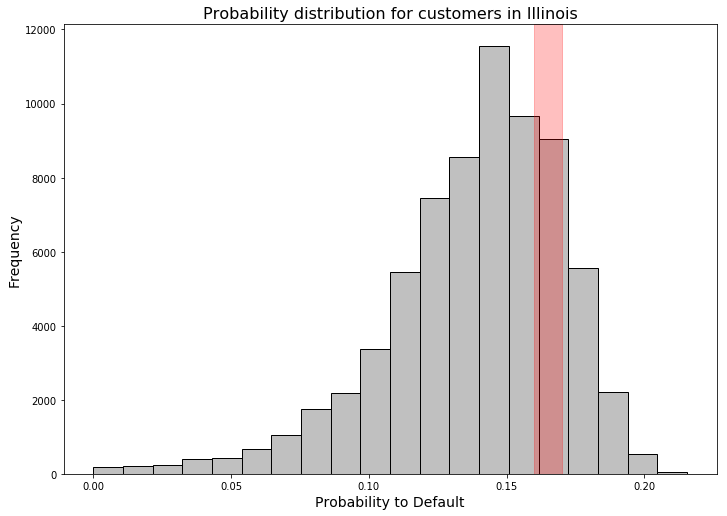

In [69]:

df2 = plot_df[plot_df['addr_state'] == 'IL']
figc, ax = plt.subplots()
figc.set_size_inches(11.7, 8.27)
plt.hist(df2.pred, color = 'silver', edgecolor = 'black',
         bins = 20)
plt.axvspan(0.16, 0.17, color='red', alpha=0.25)
plt.xlabel('Probability to Default', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Probability distribution for customers in Illinois', fontsize=16)
plt.show()

In [ ]:
loan.columns

In [71]:
from bokeh.layouts import layout
from bokeh.models.widgets import Tabs, Panel
from bokeh.io import curdoc,output_notebook, show
from bokeh.plotting import figure

output_notebook()

fig1 = figure()
fig1.circle([0,1,2],[1,3,2])
fig2 = figure()
fig2.circle([0,0,2],[4,-1,1])
fig3 = figure()
fig3.circle([0,4,3],[1,2,0])

l1 = layout([[fig1, fig2]], sizing_mode='fixed')
l2 = layout([[fig3]],sizing_mode='fixed')

tab1 = Panel(child=l1,title="This is Tab 1")
tab2 = Panel(child=l2,title="This is Tab 2")
tabs = Tabs(tabs=[ tab1, tab2 ])

curdoc().add_root(tabs)

Loading BokehJS ...

In [72]:
show(tabs)

In [73]:
p = figure(plot_width=400, plot_height=400)

In [142]:
import numpy as np
from bokeh.io import show, output_file, curdoc
from bokeh.plotting import figure
from bokeh.models import Toggle, BoxAnnotation, CustomJS, ColumnDataSource, Plot, LinearAxis, Grid
from bokeh.models.glyphs import Text


df1 = plot_df[(plot_df['rel_sal'] >= 0.75) & (plot_df['rel_sal'] < 1.25)]
hist1, edges1 = np.histogram(df1.pred, density=True, bins=30)

df1 = plot_df[plot_df['addr_state'] == 'NY']
hist2, edges2 = np.histogram(df1.pred, density=True, bins=30)

df1 = plot_df[(plot_df['int_rate'] >= 10) & (plot_df['int_rate'] < 30)]
hist3, edges3 = np.histogram(df1.pred, density=True, bins=30)


pred_score = figure(x_range=[0,1],
             y_range=[0,1])
pred_score.rect([0.5], [0.5], [0.7], [0.7],fill_alpha=0.8,fill_color='orange')


pred_score.xgrid.visible = False
pred_score.ygrid.visible = False
pred_score.xaxis.ticker = []
pred_score.yaxis.ticker = []

x = [0.3]
y = [0.4]
text = ['0.44']

source = ColumnDataSource(dict(x=x, y=y, text=text))
glyph = Text(x="x", y="y", text="text", text_color="black",text_font_size="96pt")
pred_score.add_glyph(source, glyph)


p1 = figure()
p1.quad(top=hist1, bottom=0, left=edges1[:-1], right=edges1[1:], line_color="white")

box = BoxAnnotation(left=0.1, right=0.11, fill_color='pink', fill_alpha=0.5)
p1.add_layout(box)

p2 = figure()
p2.quad(top=hist2, bottom=0, left=edges2[:-1], right=edges2[1:], line_color="white")

p3 = figure()
p3.quad(top=hist3, bottom=0, left=edges3[:-1], right=edges3[1:], line_color="white")

l0 = layout([[pred_score]], sizing_mode='fixed')
l1 = layout([[p1]], sizing_mode='fixed')
l2 = layout([[p2]],sizing_mode='fixed')
l3 = layout([[p3]],sizing_mode='fixed')

tab0 = Panel(child=l0,title="Score")
tab1 = Panel(child=l1,title="Relative Salary Analysis")
tab2 = Panel(child=l2,title="Comparison within the state")
tab3 = Panel(child=l3,title="Interest Rate Comparison")

tabs = Tabs(tabs=[ tab0,tab1, tab2, tab3 ])

show(tabs)

In [136]:
from bokeh.models import ColumnDataSource, Plot, LinearAxis, Grid
from bokeh.models.glyphs import Text
from bokeh.io import curdoc, show

pred_score = figure(x_range=[0,1],
             y_range=[0,1])
pred_score.rect([0.5], [0.5], [0.7], [0.7],fill_alpha=0.8,fill_color='orange')


pred_score.xgrid.visible = False
pred_score.ygrid.visible = False
pred_score.xaxis.ticker = []
pred_score.yaxis.ticker = []

x = [0.3]
y = [0.4]
text = ['0.44']

source = ColumnDataSource(dict(x=x, y=y, text=text))
glyph = Text(x="x", y="y", text="text", text_color="black",text_font_size="96pt")
pred_score.add_glyph(source, glyph)

show(pred_score)

In [111]:
import numpy as np

from bokeh.models import ColumnDataSource, Plot, LinearAxis, Grid
from bokeh.models.glyphs import Text
from bokeh.io import curdoc, show

x = [0.6]
y = [0.7]
text = ['abc']

source = ColumnDataSource(dict(x=x, y=y, text=text))
glyph = Text(x="x", y="y", text="text", angle=0.3, text_color="#96deb3")
plot.add_glyph(source, glyph)

['abc', 'def', 'ghi', 'jkl', 'mno', 'pqr', 'stu', 'vwx', 'yz']